In [1]:
!pip install earthengine-api
!pip install geemap
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 64.7 MB/s eta 0:00:00


In [2]:
import ee
import rasterio
import numpy as np
import pandas as pd


In [3]:
##Autenticação do GEE e inicialização
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=l67mkZZBxcnadTyWvoBDPkJMR3LCHG3mmIqj2-8CXJw&tc=apfJV_LCxZ0hMQL7lbUbf4XQ3I2U7X1zw889-EIyGeM&cc=VxMJcSQL-jEPATkkSYJ-MWnrC9QU-C50YCvjZ7aAuUc

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXkgjh35tbhwWOOcRIbI_GJ9BAzh9mLrlEPvrmWfgW9agXhFlXvMfy8

Successfully saved authorization token.


In [5]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [23]:

regiao_interesse = ee.Geometry.Polygon(
        [[[56.17014902142072,24.440849341308358],
        [56.2844754984715,24.440849341308358],
        [56.2844754984715,24.52927197746182],
        [56.17014902142072,24.52927197746182],
        [56.17014902142072,24.440849341308358]]])

# Carregar a coleção de imagens Sentinel-2
colecao = ee.ImageCollection("COPERNICUS/S2_SR") \
    .filterBounds(regiao_interesse) \
    .filterDate('2021-05-15', '2021-05-24') \
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 20)  # Definir a porcentagem máxima de cobertura de nuvens

In [24]:

# Ordenar a coleção pela cobertura de nuvens em ordem crescente
colecao_ordenada = colecao.sort('CLOUDY_PIXEL_PERCENTAGE')

In [25]:
colecao

In [26]:
import pandas as pd

# Definir uma função para mapear sobre a coleção de imagens e retornar as informações desejadas
def get_image_info(imagem):
    imagem = ee.Image(imagem)
    imagem_id = imagem.id()
    imagem_data = ee.Date(imagem.get('system:time_start')).format('yyyy-MM-dd')
    imagem_cobertura_nuvens = imagem.get('CLOUDY_PIXEL_PERCENTAGE')
    return ee.Feature(None, {'ID': imagem_id, 'Data': imagem_data, 'Cobertura de Nuvens': imagem_cobertura_nuvens})

# Mapear sobre a coleção de imagens e obter as informações como uma lista de features
lista_features = colecao_ordenada.map(get_image_info).toList(colecao_ordenada.size())

# Criar uma lista vazia para armazenar as informações das imagens
dados_imagens = []

# Iterar sobre a lista de features e extrair as informações
for feature in lista_features.getInfo():
    dados_imagens.append(feature['properties'])

# Criar o DataFrame
df_imagens = pd.DataFrame(dados_imagens)

# Exibir o DataFrame
print(df_imagens)


EEException: ignored

In [21]:

# Obter a imagem com menor cobertura de nuvens
imagem_menor_nuvens = colecao_ordenada.first()
imagem_menor_nuvens.getInfo()

In [22]:
print(imagem_menor_nuvens.bandNames().getInfo())

EEException: ignored

In [ ]:
imagem_selecionada = imagem_menor_nuvens.select("B.*")
##Vamos precisar de uma imagem sentinel para testar a acurácia

task = ee.batch.Export.image.toDrive(image=imagem_selecionada,  # um objeto ee.Image.
                                     region = regiao_interesse,
                                     description='ImagemBaixada3',
                                     folder='/drive/MyDrive/GEE_PYTHON',
                                     fileNamePrefix='baixandoimagme3',
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')

##Inicie o Download
task.start()

In [ ]:
# Converter todas as bandas para o tipo de dados UInt16
imagem_convertida = imagem_menor_nuvens.toUint16()

# Criar a tarefa de exportação para o Google Drive
task = ee.batch.Export.image.toDrive(image=imagem_convertida,
                                     region=regiao_interesse,
                                     description='ImagemBaixada',
                                     folder='/drive/MyDrive/GEE_PYTHON',
                                     fileNamePrefix='BaixandoImagem',
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')

# Iniciar o download
task.start()


In [27]:

regiao_interesse = ee.Geometry.Polygon(
        [[[56.17014902142072,24.440849341308358],
        [56.2844754984715,24.440849341308358],
        [56.2844754984715,24.52927197746182],
        [56.17014902142072,24.52927197746182],
        [56.17014902142072,24.440849341308358]]])

# Carregar a coleção de imagens Sentinel-2
imagem = ee.ImageCollection("COPERNICUS/S2_SR") \
    .filterBounds(regiao_interesse) \
    .filterDate('2021-05-20', '2021-05-24') \
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 5).median()

In [29]:
imagem

In [28]:
imagem_selecionada = imagem.select("B.*")


task = ee.batch.Export.image.toDrive(image=imagem_selecionada,  # um objeto ee.Image.
                                     region = regiao_interesse,
                                     description='ImagemMediana',
                                     folder='/drive/MyDrive/GEE_PYTHON',
                                     fileNamePrefix='ImagemMediana',
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')

##Inicie o Download
task.start()

# ***Selecionar imagem no GEE***

<Axes: >

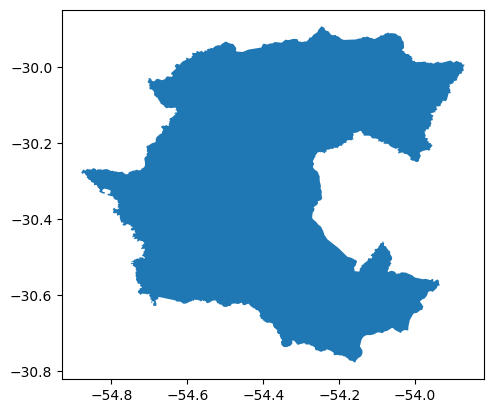

In [ ]:
###Selecionando área com o GeoBr
gdf = geobr.read_municipality(code_muni=4318309, year=2020)
gdf.crs = 'EPSG:4326'
gdf.plot()

In [ ]:
##Obter o centroid
centroid = gdf.centroid
x =str(centroid.x)[4:-15]
y =str(centroid.y)[4:-15]

In [ ]:
##Converter shp to json
shp_json = gdf.to_json()
region = json.loads(shp_json)
region = region['features']
region

In [ ]:
##Definição de featureCollection
roi = ee.FeatureCollection(region)

In [ ]:
##Selecionando imagem
srtm = ee.Image("NASA/NASADEM_HGT/001").select('elevation').clip(roi)

##Visualizando sombreado
Map = geemap.Map(location =[y,x], zoom=10 )
Map.addLayer(srtm, {'palette':['grey','green','darkgreen','orange','red','darkred'],'min':0, 'max':300}, 'SRTM');
Map

Map(center=['  -30.30525', '  -54.3654'], controls=(WidgetControl(options=['position', 'transparent_bg'], widg…

# ***Exportar imagem e abrir com rasterio***

In [ ]:
##Exportando os dados
task = ee.batch.Export.image.toDrive(image=srtm.toFloat(),  # um objeto ee.Image.
                                     region=roi.geometry(),  # um objeto ee.Geometry.
                                     description='srtm',
                                     folder='BASES',
                                     fileNamePrefix='srtm',
                                     scale=30,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')

##Inicie o Download
task.start()

In [ ]:
##Verificar status
task.status()

{'state': 'COMPLETED',
 'description': 'srtm',
 'creation_timestamp_ms': 1685044662008,
 'update_timestamp_ms': 1685044890338,
 'start_timestamp_ms': 1685044673420,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/1UVgApzn8BnMBoHSezzS8y78808K4lAUX'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 10.754966735839844,
 'id': 'SB53IN27UNN6YVGYEVB4RT7R',
 'name': 'projects/earthengine-legacy/operations/SB53IN27UNN6YVGYEVB4RT7R'}

# **Calcular o NDVI da região**

Acesseo link -> https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED#bands

In [ ]:
##Selecionar nossa coleção
collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
                                  .filterDate('2021-01-01','2022-01-01')\
                                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',1))\
                                  .filterBounds(ee.Geometry.Point([float(x),float(y)]))\
                                  .sort('CLOUDY_PIXEL_PERCENTAGE')\
                                  .median()\
                                  .multiply(0.0001).clip(roi)
##Calculo do NDVI
ndvi = collection.normalizedDifference(['B8','B4']).rename('ndvi')

In [ ]:
##Adicionar o Layer
Map_ = geemap.Map(location =[y,x], zoom=10 )
Map_.addLayer(ndvi, {'palette':['red','yellow','green'],'min':-1, 'max':1}, 'NDVI');
Map_

Map(center=['  -30.30525', '  -54.3654'], controls=(WidgetControl(options=['position', 'transparent_bg'], widg…

In [ ]:
##Exportando os dados
task = ee.batch.Export.image.toDrive(image=ndvi.clip(roi),  # um objeto ee.Image.
                                     region=roi.geometry(),  # um objeto ee.Geometry.
                                     description='ndvi',
                                     folder='BASES',
                                     fileNamePrefix='ndvi',
                                     scale=30,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')
##Inicie o Download
task.start()

In [ ]:
task.status()

{'state': 'COMPLETED',
 'description': 'ndvi',
 'creation_timestamp_ms': 1685043510022,
 'update_timestamp_ms': 1685043772466,
 'start_timestamp_ms': 1685043518858,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/1UVgApzn8BnMBoHSezzS8y78808K4lAUX'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 411.197509765625,
 'id': 'ZBHK4IWKKM66D7D7IQRZ3HXW',
 'name': 'projects/earthengine-legacy/operations/ZBHK4IWKKM66D7D7IQRZ3HXW'}